<div class="alert alert-info">

## **Experiments**

In this notebook we test extracting features from the videos using different feature extractors & with then train a Dense and LSTM network on the extracted features.

</div>

<div class="alert alert-success">

- [ ] Retry experiments but with normalized features or Batch Normalization & more complex networks.
- [ ] Try with YOLO centered key points to the body center.
- [ ] Try with all features + appended optical flow or yolo key points.

</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import tqdm
import torch

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from tas_helpers.visualization import SegmentationVisualizer
from tas_helpers.scores import repetition_score, order_variation_score
from tas_helpers.metrics import mean_over_frames, f1_score, edit_distance

from helpers.misc import plot_model_performances

from cached_dataset import DiskCachedDataset

from utils import LabelEncoderFactory
from utils import generate_positional_encoding

from helpers.preparations import preparations
from helpers.misc import split_generator, videos_to_indices, aggregate_folds_histories

# --- --- ---

from helpers.constants import \
    FeaturesType, \
    DATASET_PATH, \
    VIDEOS_DIRECTORY_NAME, \
    ANNOTATIONS_DIRECTORY_NAME, \
    VIDEOS_FRAMES_DIRECTORY_NAME, \
    ANNOTATED_IDS_FILE_NAME, \
    UNANNOTATED_IDS_FILE_NAME, \
    TESTING_PERCENTAGE, \
    NUMBER_OF_FOLDS, \
    FEATURES_EXTRACTORS
    

Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


[missing-keys]: <All keys matched successfully>


Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [4]:
label_encoder = LabelEncoderFactory.get()

<div class="alert alert-info">

### **Pre-Processing**

The preprocessing step includes:
- Transforming the videos dataset into per frame dataset.
- Creating all the video datasets with the transforms for each backbone feature extractor.
- Extracting and caching all the backbone models' features for faster training and inference.
- $\cdots$

</div>

In [ ]:
outputs = preparations()

datasets = outputs['datasets']
FEATURES_EXTRACTORS = outputs['FEATURES_EXTRACTORS']
video_segments_mapping = outputs['video_segments_mapping']
disk_cached_datasets = outputs['disk_cached_datasets']

[INFO]: frames for "climb_1-climber_MoubeAdrian-bloc_1-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_1-climber_MoubeAdrian-bloc_1-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_10-climber_DouglasSophia-bloc_1-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_10-climber_DouglasSophia-bloc_1-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_11-climber_MoubeAdrian-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_11-climber_MoubeAdrian-bloc_2-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_12-climber_MrideEsteban-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_12-climber_MrideEsteban-bloc_2-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_13-climber_FonneLana-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_13-climber_FonneLana-blo

[caching-dataset]:  46%|████▌     | 1883/4098 [1:50:52<2:16:04,  3.69s/it]

<div class="alert alert-info">

### **Backbones Features Shapes:**

Showcase of the different backbone models and their corresponding feature shape.

</div>

In [108]:
for dataset, extractor in zip(datasets, FEATURES_EXTRACTORS):
    print(f"[{extractor['name']}]:", end=" ")
    print(dataset[0][0].shape)

[averaged-dino]: torch.Size([384])
[dino]: torch.Size([8, 384])
[resnet-3d]: torch.Size([2048])
[i3d]: torch.Size([1024])
[clip]: torch.Size([8, 512])
[x3d-xs]: torch.Size([2048])
[x3d-s]: torch.Size([2048])
[x3d-m]: torch.Size([2048])
[yolo]: torch.Size([8, 34])
[s3d-kinetics]: torch.Size([1024])
[s3d-howto100m]: torch.Size([1024])
[slowfast]: torch.Size([2304])


In [109]:
annotated_videos_ids = np.loadtxt(os.path.join(DATASET_PATH, ANNOTATED_IDS_FILE_NAME), dtype=str)

print(f"[#videos]: {len(annotated_videos_ids)}")

[#videos]: 22


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

In [114]:
from simplest.trainer import Trainer

from simplest.simple_linear_classifier import SimpleLinearClassifier
from simplest.complex_linear_classifier import ComplexLinearClassifier

<div class="alert alert-info">

### **Training Models**

</div>

In [115]:
from helpers.filters import with_ignore_classes, with_ignore_pensionless_segments

In [ ]:
def with_positional_encoding(dataset):
    """
    Transform the dataset to include positional encoding.
    """
    pass

In [67]:
folds_histories = []

for fold_index, folds in enumerate(split_generator(NUMBER_OF_FOLDS)):
    histories = []
    
    for extractor in FEATURES_EXTRACTORS:
        training_videos_ids, testing_videos_ids = folds
    
        training_samples_ids = videos_to_indices(training_videos_ids)
        testing_samples_ids = videos_to_indices(testing_videos_ids)
        
        # TODO: try ignoring the chronometer class too
        training_dataset = with_ignore_pensionless_segments(with_ignore_classes(["nothing"], DiskCachedDataset(
            base_path=os.path.join(DATASET_PATH, extractor["features-directory-name"]),
            verbose=True,
            ids=training_samples_ids,
            # TODO: just here include x[-1] or something like that, like the previous sample in order to use it in the LSTM
            transform=lambda x: (x[0], x[1])
        )))

        # TODO: try ignoring the chronometer class too
        testing_dataset = with_ignore_pensionless_segments(with_ignore_classes(["nothing"], DiskCachedDataset(
            base_path=os.path.join(DATASET_PATH, extractor["features-directory-name"]),
            verbose=True,
            ids=testing_samples_ids,
            # TODO: just here include x[-1] or something like that, like the previous sample in order to use it in the LSTM
            transform=lambda x: (x[0], x[1])
        )))
        
        training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
        testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=32, shuffle=False)
    
        linear_classifier = SimpleLinearClassifier(input_size=training_dataset[0][0].shape[0], output_size=len(label_encoder.classes_)).to(device)
        
        trainer = Trainer(linear_classifier)
        
        history, best_training_accuracy, best_validation_accuracy, best_epoch = trainer.train(training_dataloader, testing_dataloader, title=f"[training-{extractor['name']}-{fold_index + 1}/{NUMBER_OF_FOLDS}]")
        
        histories.append((history, best_training_accuracy, best_validation_accuracy, best_epoch))
        
    folds_histories.append(histories)

[training-slowfast-5/5]: 100%|██████████| 32/32 [00:15<00:00,  2.02epoch/s, training-loss=0.14, training-accuracy=0.973, validation-loss=0.983, validation-accuracy=0.75, best-validation-accuracy=0.783, best-training-accuracy=0.848]  


In [ ]:
number_of_models = len(FEATURES_EXTRACTORS)

figure, axes = plt.subplots(nrows=(number_of_models+1)//2, ncols=2, figsize=(15, 4*((number_of_models+1)//2)))

axes = axes.flatten()

min_loss = float('inf')
max_loss = float('-inf')

for (history, best_training_accuracy, best_validation_accuracy, best_epoch), extractor in zip(histories, FEATURES_EXTRACTORS):
    name = extractor['name']
    min_loss = min(min_loss, 
                  min(history['training_loss']), 
                  min(history['testing_loss']))
    max_loss = max(max_loss, 
                   max(history['training_loss']), 
                   max(history['testing_loss']))

for idx, (history, best_training_accuracy, best_validation_accuracy, best_epoch), extractor in zip(range(len(histories)), histories, FEATURES_EXTRACTORS):
    name = extractor['name']
    
    axes[idx].plot(history['training_loss'], label='Training Loss')
    axes[idx].plot(history['testing_loss'], label='Testing Loss')
    
    axes[idx].set_title(f'{name.upper()} Loss')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid(True)
    
    # axes[idx].set_ylim(min_loss, max_loss)

if number_of_models % 2 != 0:
    figure.delaxes(axes[-1])

plt.tight_layout()

# NOTE: uncomment to display the plot
# plt.show()

plt.close()

<div class="alert alert-info">

### **Models Performances Preview**

</div>

In [87]:
histories, best_scores, validation_accuracies, training_accuracies = aggregate_folds_histories(folds_histories)

In [129]:
for extractor, (average_best_training_score, average_best_validation_score, variance_best_training_score, variance_best_validation_score) in zip(FEATURES_EXTRACTORS, best_scores):
    print(f"[{extractor["name"]}]: {(average_best_validation_score * 100):.02f}% ± {(variance_best_validation_score * 100):.02f}%")

[averaged-dino]: 76.43% ± 0.22%
[dino]: 75.54% ± 0.40%
[resnet-3d]: 81.42% ± 0.18%
[i3d]: 73.93% ± 0.58%
[clip]: 72.27% ± 0.03%
[x3d-xs]: 80.68% ± 0.20%
[x3d-s]: 82.54% ± 0.18%
[x3d-m]: 82.01% ± 0.16%
[yolo]: 60.88% ± 0.51%
[s3d-kinetics]: 75.43% ± 0.30%
[s3d-howto100m]: 56.87% ± 0.50%
[slowfast]: 80.92% ± 0.11%


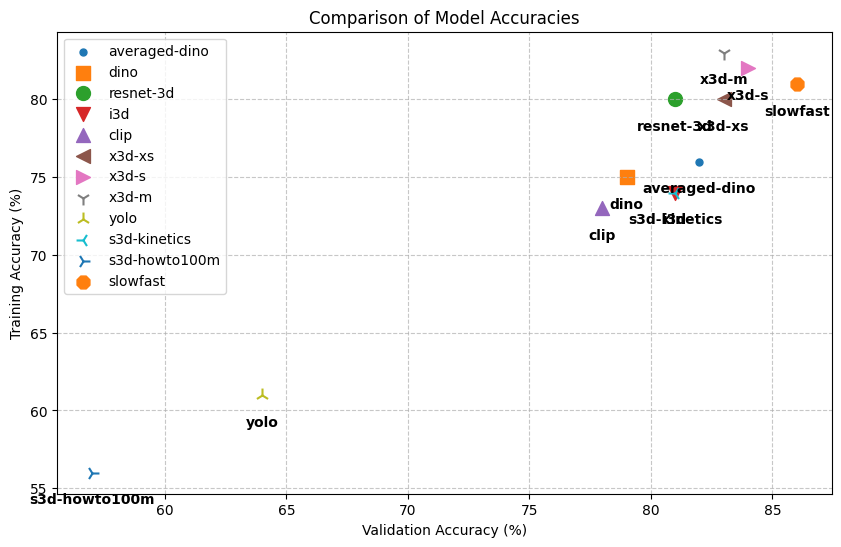

In [130]:
model_names = [extractor["name"] for extractor in FEATURES_EXTRACTORS]

plot_model_performances(model_names, validation_accuracies, training_accuracies)

<div class="alert alert-info">

### **Confusion Matrices**

</div>

In [131]:
#

<div class="alert alert-info">

### **Segmentation Visualization**

</div>

---

### About Dino

<div class="alert alert-info">

**Dino Model Card:** https://github.com/facebookresearch/dinov2/blob/main/MODEL_CARD.md

**Dino for Video Classification:** https://github.com/facebookresearch/dinov2/issues/16

**Note on UniformTemporalSubSample Size:** Increasing it will give better results but increase loading time. https://github.com/facebookresearch/dinov2/issues/16#issuecomment-1521403076

</div>

<div class="alert alert-warning">

**`patchtokens`** are the image token / patches embeddings after they have been passed through the network and the 324 is here because we have a total of 324 patches.

**`clstoken`** is the cls token that is supposed to contain all the relevant information about the image.

**`regtokens`** are regularization tokens and they only help improve feature diversity and representation during training. Only 4 are used in this model.

**`prenorm`** is represent the combined tokens before the layer normalization (1 [CLS Token] + 4 Regularization Tokens + 324 Patch Tokens = 329).

The 768 is the patch embedding size that is used by Deno. And the 16 that keeps reappearing is the batch size since we are using a sample of 16 frames.

```bash
[features.keys()]: dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])
[number_of_patches]: 324
[x_norm_clstoken]: torch.Size([16, 768])
[x_norm_regtokens]: torch.Size([16, 4, 768])
[x_norm_patchtokens]: torch.Size([16, 324, 768])
[x_prenorm]: torch.Size([16, 329, 768])
[masks]: None
```

</div>

<div class="alert alert-success">

**Questions**
- [ ] Why are we using the last hidden state rather than the last memory cell or output ?

</div>

---

### About I-Jepa

<div class="alert alert-warning">


- [ ] **Checkout** [This Site](https://paperswithcode.com/sota/action-classification-on-kinetics-600?p=video-swin-transformer) for a leaderboard on video classification task.

- [ ] Experiment with features from I-Jepa
- [ ] Experiment with features from VideoMAE-ViT-H/16; OmniMAE-ViT-H/16 and VideoMAEv2-ViT-g/14 and other ViT based models for features extraction.
- [ ] Experiment on fine tuning ViT for a specific task using some unlabelled videos or reinforcement learning.
- [ ] Try to perform some sort of clustering and visualizations on using Umap and PCA on these extracted features on different models, do this for features from different models such as ViT, resnet, Video CNNs, etc.

</div>

<div class="alert alert-warning">

- [ ] Is this [Repository](https://github.com/kylemin/S3D) the same as the one we took the S3D model from ?

</div>

<div class="alert alert-info">

**Introduction Video About Image-Jepa:** https://www.youtube.com/watch?v=6bJIkfi8H-E

**V-Jepa Paper:** [Here](https://scontent-lhr8-2.xx.fbcdn.net/v/t39.2365-6/427986745_768441298640104_1604906292521363076_n.pdf?_nc_cat=103&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=G-D4kApr8TQQ7kNvgFSoEBh&_nc_oc=AdiZo1b5QaDaQaf0hctrozKJ2vjIp_iQvUZxArm_8k3ngVZNVLtltyVFidEIN-Njt9g&_nc_zt=14&_nc_ht=scontent-lhr8-2.xx&_nc_gid=AzzCS9ed8AZ-B2iLuVB7EE0&oh=00_AYB3kfkI_sVH0UVTrzunG99_ThmOVCNN7sRu9q9XS7nAPw&oe=67BCDFF1).

</div>

### About YOLO

<div class="alert alert-info">

`keypoints = torch.tensor(result.keypoints[0].xyn)`. the `xyn` gives the normalized version of the `xy` keypoints, the "n" stands for "normalized".

</div>